# DK - Derman Kani Binomial Tree Model

> Author: Gustavo Monteiro de Athayde  
> Monitor: Sylvio Ximenez de Azevedo Neto - <<sylvioxan@insper.edu.br>>  
> Date: 22/03/2025

In [48]:
# dependencies
from lib import derivatives as dg               # course library
from lib import derivatives_binomial as bm      # course library
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xlwings as xw

In [49]:
# parameters
S0 = 100
K = 100
rf = 0.02
T = 1
vol = 0.402704657663518
sigma = 40

bs = dg.bs_call_option(S0, K, T, rf, vol)

bs_true = np.exp(-rf*T) * ((S0 * np.exp(rf*T)-S0) * norm.cdf((S0 * np.exp(rf*T)-S0)/(sigma*np.sqrt(T))) + (sigma * np.sqrt(T) * norm.pdf((S0 * np.exp(rf*T)-S0)/(sigma*np.sqrt(T)))))

error_quad = np.log((bs/bs_true))**2*99999

In [50]:
error_quad

np.float64(8.836205758654334)

In [51]:
ccr_prices = bm.calc_spot_tree(S0, vol, T, 4)
ccr_prices

,0,1,2,3,4
0,100.0,122.305561,149.586503,182.952613,223.761220
1,NaN,81.762431,100.000000,122.305561,149.586503
2,NaN,NaN,66.850951,81.762431,100.000000
3,NaN,NaN,NaN,54.658963,66.850951
4,NaN,NaN,NaN,NaN,44.690496


In [52]:
def traverse_all_paths(df):
    paths = []
    def traverse_path(i, j, path):
        if i >= df.shape[0] or j >= df.shape[1] or pd.isna(df.iloc[i, j]):
            return
        path.append(df.iloc[i, j])
        if j == df.shape[1] - 1:
            paths.append(path.copy())
        else:
            traverse_path(i, j + 1, path)
            traverse_path(i + 1, j + 1, path)
        path.pop()

    traverse_path(0, 0, [])
    return pd.DataFrame(paths)


ccr_paths = traverse_all_paths(ccr_prices)

In [53]:
ccr_paths

,0,1,2,3,4
0,100.0,122.305561,149.586503,182.952613,223.761220
1,100.0,122.305561,149.586503,182.952613,149.586503
2,100.0,122.305561,149.586503,122.305561,149.586503
3,100.0,122.305561,149.586503,122.305561,100.000000
4,100.0,122.305561,100.000000,122.305561,149.586503
5,100.0,122.305561,100.000000,122.305561,100.000000
6,100.0,122.305561,100.000000,81.762431,100.000000
7,100.0,122.305561,100.000000,81.762431,66.850951
8,100.0,81.762431,100.000000,122.305561,149.586503
9,100.0,81.762431,100.000000,122.305561,100.000000


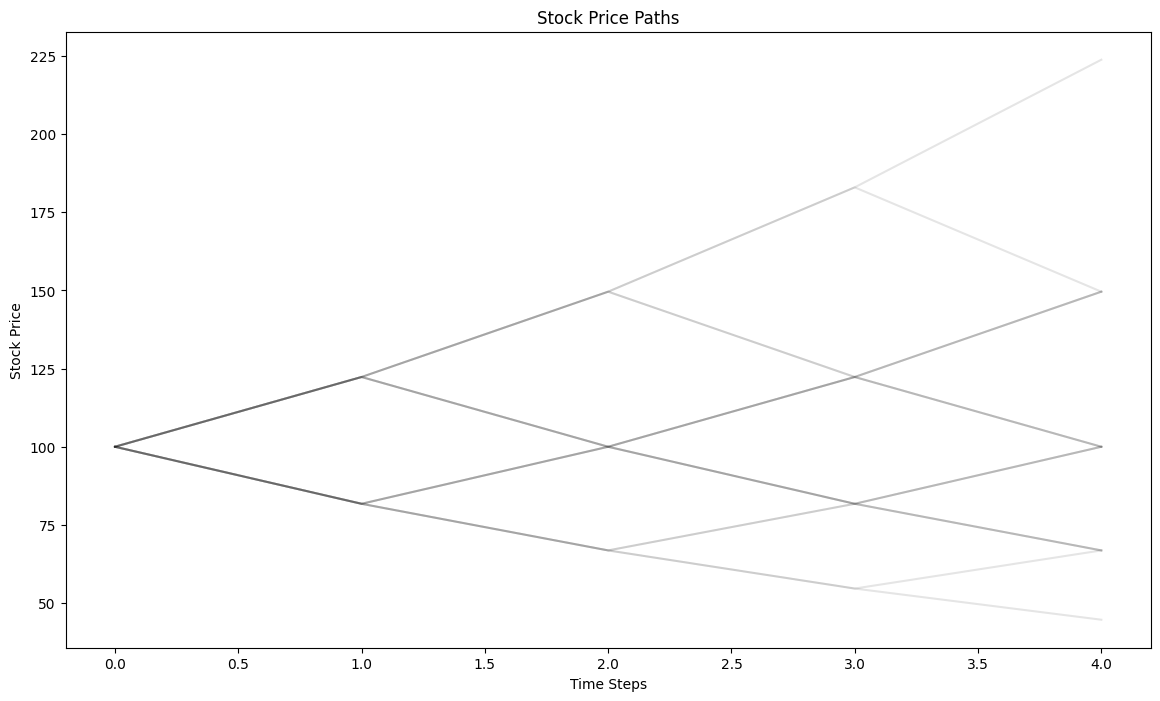

In [54]:
# plot the paths
plt.figure(figsize=(14, 8))
for i in range(ccr_paths.shape[0]):
    plt.plot(ccr_paths.columns, ccr_paths.iloc[i, :], color='black', alpha=0.1)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths')
plt.show()

In [55]:
def prob_tree(S0, vol, T, steps):

    prob = bm.calc_probability(rf, 0, vol, T, steps)

    df = pd.DataFrame(index=range(steps+1), columns=range(steps+1))
    
    for i in range(steps):
        for j in range(i+1):
            df.iloc[j, i] = prob

    return df

prob = prob_tree(S0, vol, T, 4)

def arrow_debreu_tree(prob, rf, T):    

    # df filled with 0    
    df = pd.DataFrame(np.zeros((prob.shape[0], prob.shape[1])))
    
    df.iloc[0, 0] = 1

    # replace prob nan to zeros
    prob = prob.fillna(0)

    for j in range(1, prob.shape[0]):
        df.iloc[0, j] = (df.iloc[0, j-1] * prob.iloc[0, j-1]) * np.exp(-rf*T/4)

    for i in range(1, prob.shape[0]):
        for j in range(i, prob.shape[0]):
            df.iloc[i, j] = (df.iloc[i-1, j-1] * (1-prob.iloc[i-1, j-1]) + df.iloc[i, j-1] * prob.iloc[i, j-1]) * np.exp(-rf*T/4)
            
    return df

ad = arrow_debreu_tree(prob, rf, T)

C:\Users\sazevedo\AppData\Local\Temp\ipykernel_51584\555110338.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prob = prob.fillna(0)


In [56]:
prob

,0,1,2,3,4
0,0.462195,0.462195,0.462195,0.462195,NaN
1,NaN,0.462195,0.462195,0.462195,NaN
2,NaN,NaN,0.462195,0.462195,NaN
3,NaN,NaN,NaN,0.462195,NaN
4,NaN,NaN,NaN,NaN,NaN


In [57]:
ad

,0,1,2,3,4
0,1.0,0.459890,0.211498,0.097266,0.044732
1,0.0,0.535123,0.492195,0.339533,0.208197
2,0.0,0.000000,0.286357,0.395077,0.363384
3,0.0,0.000000,0.000000,0.153236,0.281886
4,0.0,0.000000,0.000000,0.000000,0.082000


### Derman-Kani Tree

In [37]:
# import data from excel
wb = xw.Book('dk_binomial_tree_xl.xlsx')

sht = wb.sheets['DK']

# get prices
prices_values = sht.range('dk_prices').value
dk_prices = pd.DataFrame(prices_values)

# get probabilities
prob_values = sht.range('dk_probs').value
dk_prob = pd.DataFrame(prob_values)

# get market calls and puts
market_values = sht.range('dk_market').value
dk_market = pd.DataFrame(market_values)

# get Arrow-Debreu - Real probabilities
ad_values = sht.range('dk_ad').value
dk_ad = pd.DataFrame(ad_values)


In [38]:
dk_prices

,0,1,2,3,4
0,100.0,117.300128,141.444829,160.503989,182.929969
1,NaN,85.251399,100.000000,120.037149,139.033284
2,NaN,NaN,53.742054,83.307543,100.000000
3,NaN,NaN,NaN,42.256166,60.657203
4,NaN,NaN,NaN,NaN,18.449979


In [39]:
dk_prob

,0,1,2,3,4
0,0.475833,0.431612,0.546538,0.507447,None
1,NaN,0.690404,0.468116,0.528750,None
2,NaN,NaN,0.286355,0.586331,None
3,NaN,NaN,NaN,0.569049,None
4,NaN,NaN,NaN,NaN,None


In [40]:
dk_market

,0,1,2,3,4
0,None,8.19092,4.909390,2.107456,1.252060
1,None,NaN,NaN,14.371374,8.372007
2,None,NaN,5.062456,12.882568,NaN
3,None,NaN,NaN,1.310380,8.151733
4,None,NaN,NaN,NaN,1.164604


In [42]:
dk_ad

,0,1,2,3,4
0,1.0,0.473460,0.203332,0.110574,0.055831
1,NaN,0.521552,0.626053,0.383347,0.255876
2,NaN,NaN,0.160665,0.377105,0.399757
3,NaN,NaN,NaN,0.114086,0.219815
4,NaN,NaN,NaN,NaN,0.048920


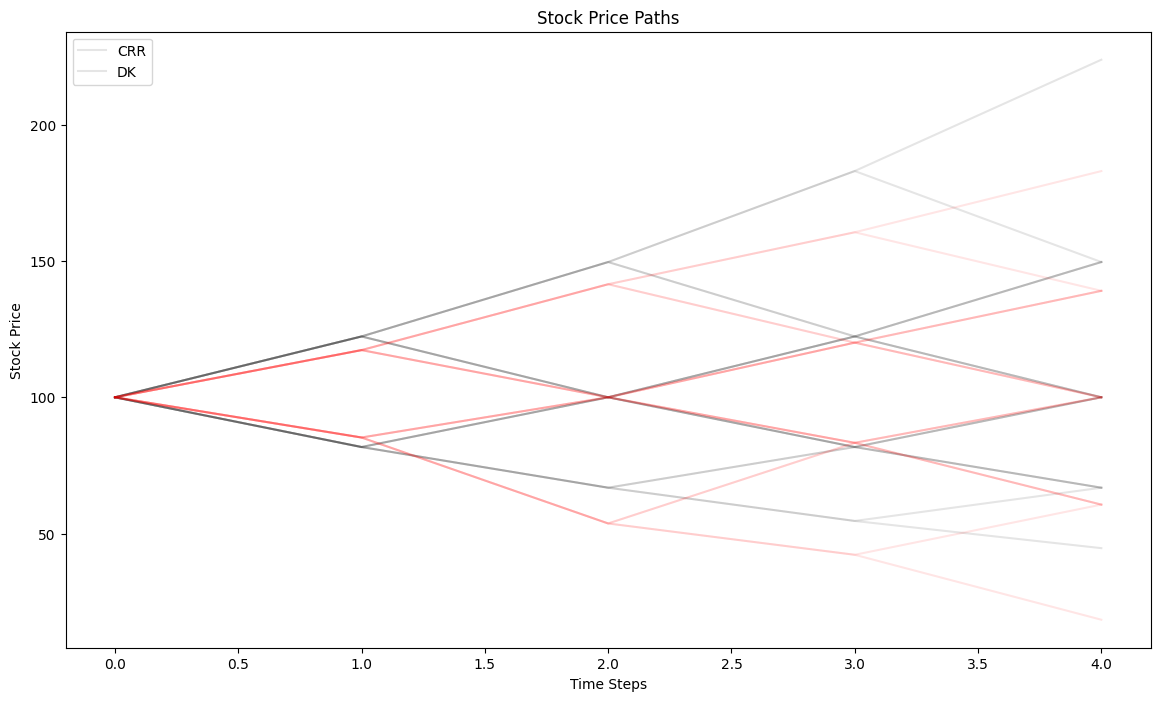

In [45]:
dk_paths = traverse_all_paths(dk_prices)


# plot the ccr and dk paths
plt.figure(figsize=(14, 8))
for i in range(ccr_paths.shape[0]):
    plt.plot(ccr_paths.columns, ccr_paths.iloc[i, :], color='black', alpha=0.1)
for i in range(dk_paths.shape[0]):
    plt.plot(dk_paths.columns, dk_paths.iloc[i, :], color='red', alpha=0.1)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths')
# legend
plt.legend(['CRR', 'DK'])
plt.show()


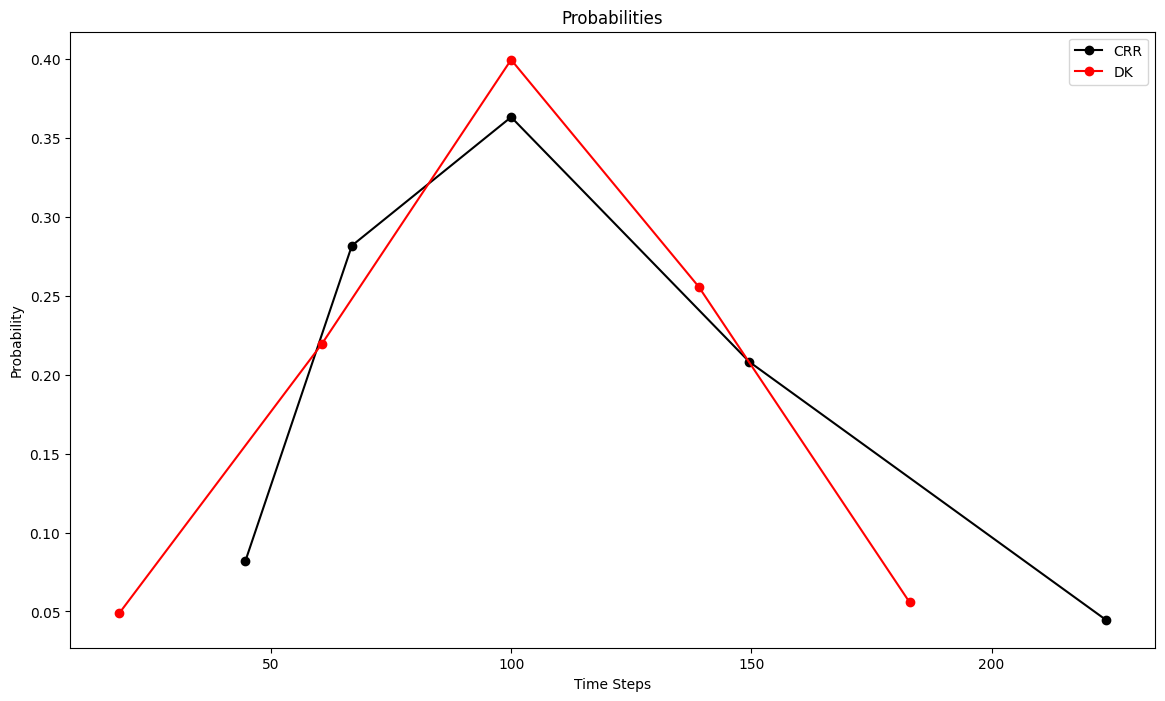

In [67]:
# plot the ccr and dk probabilities
plt.figure(figsize=(14, 8))
plt.plot(ccr_prices.iloc[:, 4], ad.iloc[:, 4], color='black', marker='o')
plt.plot(dk_prices.iloc[:, 4], dk_ad.iloc[:,4], color='red', marker='o')
plt.xlabel('Time Steps')
plt.ylabel('Probability')   
plt.title('Probabilities')
# legend
plt.legend(['CRR', 'DK'])
plt.show()

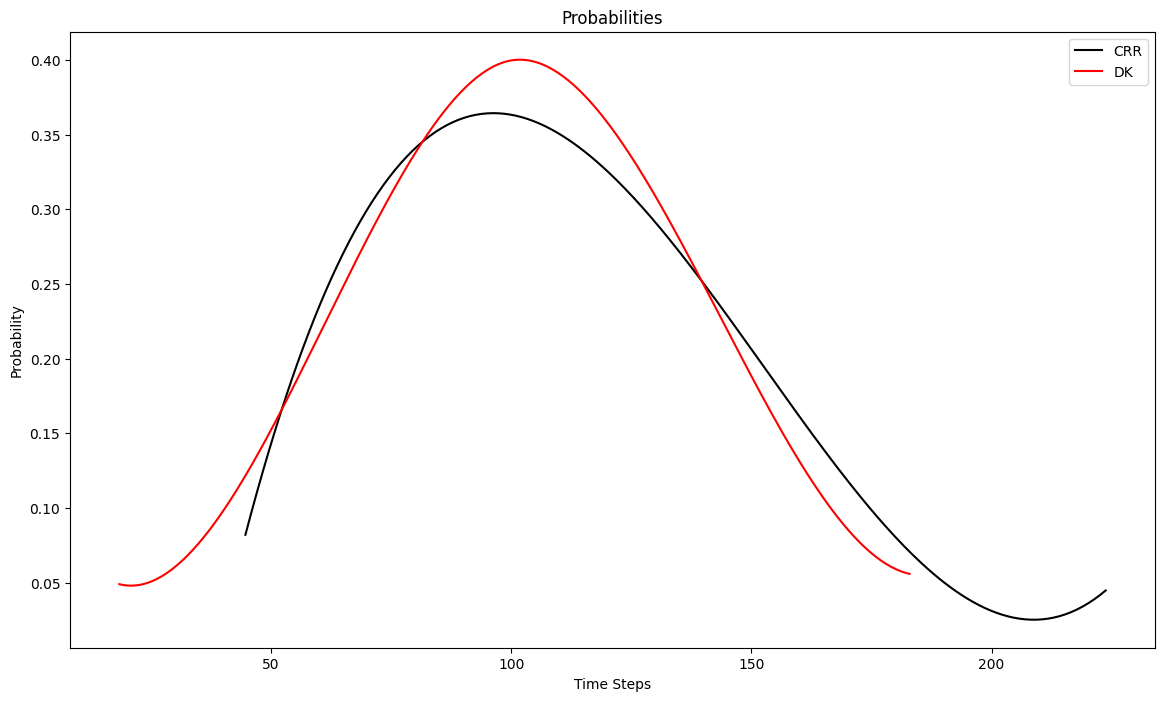

In [72]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Generate smooth curves
def smooth_curve(x, y):
    # Sort x and y based on x values
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    x_new = np.linspace(x_sorted.min(), x_sorted.max(), 300) 
    spl = make_interp_spline(x_sorted, y_sorted, k=3)  # BSpline object
    y_smooth = spl(x_new)
    return x_new, y_smooth

# plot the ccr and dk probabilities
plt.figure(figsize=(14, 8))

# Smooth the CCR data
x_ccr, y_ccr = smooth_curve(ccr_prices.iloc[:, 4], ad.iloc[:, 4])
plt.plot(x_ccr, y_ccr, color='black')

# Smooth the DK data
x_dk, y_dk = smooth_curve(dk_prices.iloc[:, 4], dk_ad.iloc[:, 4])
plt.plot(x_dk, y_dk, color='red')

plt.xlabel('Time Steps')
plt.ylabel('Probability')   
plt.title('Probabilities')
# legend
plt.legend(['CRR', 'DK'])
plt.show()

In [61]:
dk_ad

,0,1,2,3,4
0,1.0,0.473460,0.203332,0.110574,0.055831
1,NaN,0.521552,0.626053,0.383347,0.255876
2,NaN,NaN,0.160665,0.377105,0.399757
3,NaN,NaN,NaN,0.114086,0.219815
4,NaN,NaN,NaN,NaN,0.048920
